# News Sentiment Analysis - Data Exploration

This notebook provides a comprehensive exploration of the financial news sentiment dataset. We'll analyze the data distribution, text characteristics, and prepare insights for model development.

## Dataset Overview

The dataset contains financial news articles labeled with sentiment (positive, negative, neutral). This analysis will help us understand:
- Data distribution and class balance
- Text length and token statistics
- Vocabulary characteristics
- Sentiment patterns and examples

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from collections import Counter
import re
from wordcloud import WordCloud
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading and Initial Inspection

In [2]:
# Load the processed dataset
data_path = Path('../data/financial_news/processed_all-data.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (4846, 7)
Columns: ['original_id', 'chunk_id', 'text', 'is_long', 'total_chunks', 'num_tokens', 'sentiment']

First few rows:


,original_id,chunk_id,text,is_long,total_chunks,num_tokens,sentiment
0,0,0,"According to Gran , the company has no plans t...",False,1,25,neutral
1,1,0,Technopolis plans to develop in stages an area...,False,1,34,neutral
2,2,0,The international electronic industry company ...,False,1,41,negative
3,3,0,With the new production plant the company woul...,False,1,34,positive
4,4,0,According to the company 's updated strategy f...,False,1,49,positive


In [3]:
# Basic dataset information
print("Dataset Info:")
print(f"Total number of articles: {df.shape[0]:,}")
print(f"Unique original articles: {df['original_id'].nunique():,}")
print(f"Articles that were chunked: {df[df['total_chunks'] > 1]['original_id'].nunique():,}")
print(f"Total chunks: {df.shape[0]:,}")

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
Total number of articles: 4,846
Unique original articles: 4,846
Articles that were chunked: 0
Total chunks: 4,846

Data Types:
original_id      int64
chunk_id         int64
text            object
is_long           bool
total_chunks     int64
num_tokens       int64
sentiment       object
dtype: object

Missing Values:
original_id     0
chunk_id        0
text            0
is_long         0
total_chunks    0
num_tokens      0
sentiment       0
dtype: int64


## Sentiment Distribution Analysis

Sentiment Distribution:
Neutral: 2,879 (59.4%)
Positive: 1,363 (28.1%)
Negative: 604 (12.5%)


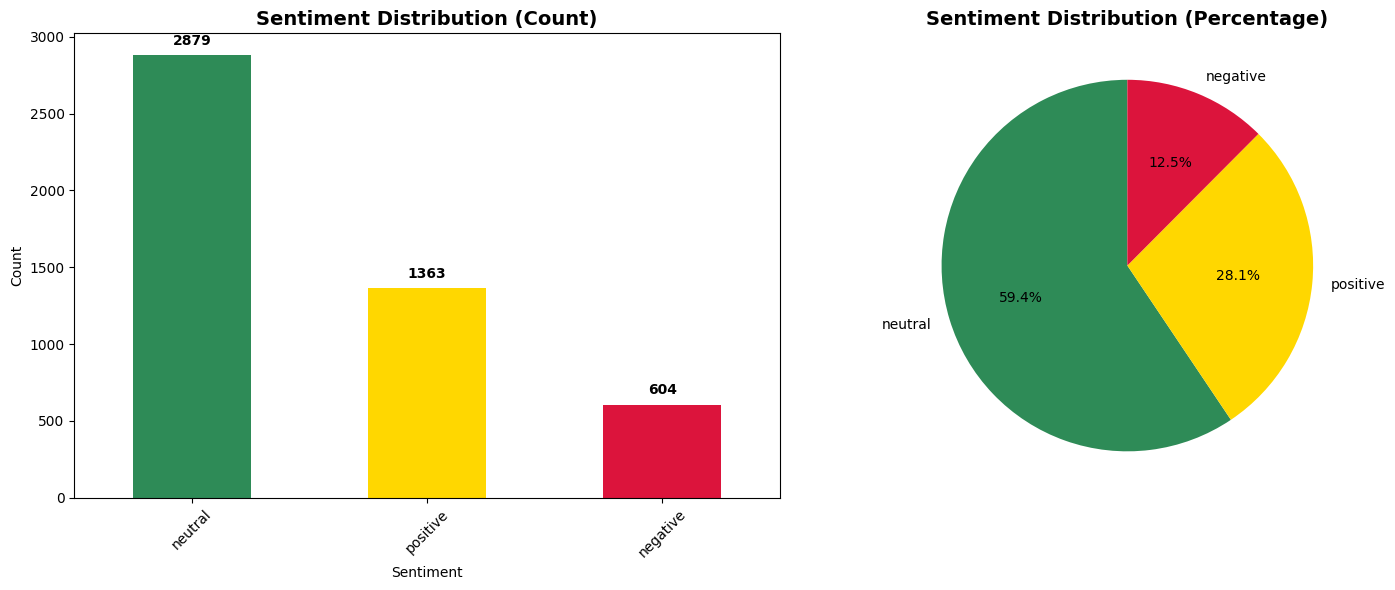

In [4]:
# Sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_pct = df['sentiment'].value_counts(normalize=True) * 100

print("Sentiment Distribution:")
for sentiment in sentiment_counts.index:
    count = sentiment_counts[sentiment]
    pct = sentiment_pct[sentiment]
    print(f"{sentiment.capitalize()}: {count:,} ({pct:.1f}%)")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
sentiment_counts.plot(kind='bar', ax=ax1, color=['#2E8B57', '#FFD700', '#DC143C'])
ax1.set_title('Sentiment Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add count labels on bars
for i, v in enumerate(sentiment_counts.values):
    ax1.text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#2E8B57', '#FFD700', '#DC143C']
wedges, texts, autotexts = ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Text Length Analysis

In [5]:
# Calculate text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("Text Length Statistics:")
print("\nCharacter Length:")
print(df['text_length'].describe())
print("\nWord Count:")
print(df['word_count'].describe())
print("\nToken Count (from preprocessing):")
print(df['num_tokens'].describe())

Text Length Statistics:

Character Length:
count    4846.000000
mean      128.015064
std        56.503011
min         9.000000
25%        84.000000
50%       119.000000
75%       163.000000
max       315.000000
Name: text_length, dtype: float64

Word Count:
count    4846.000000
mean       23.095130
std         9.958108
min         2.000000
25%        16.000000
50%        21.000000
75%        29.000000
max        81.000000
Name: word_count, dtype: float64

Token Count (from preprocessing):
count    4846.000000
mean       28.566447
std        13.599916
min         2.000000
25%        19.000000
50%        26.000000
75%        36.000000
max       148.000000
Name: num_tokens, dtype: float64


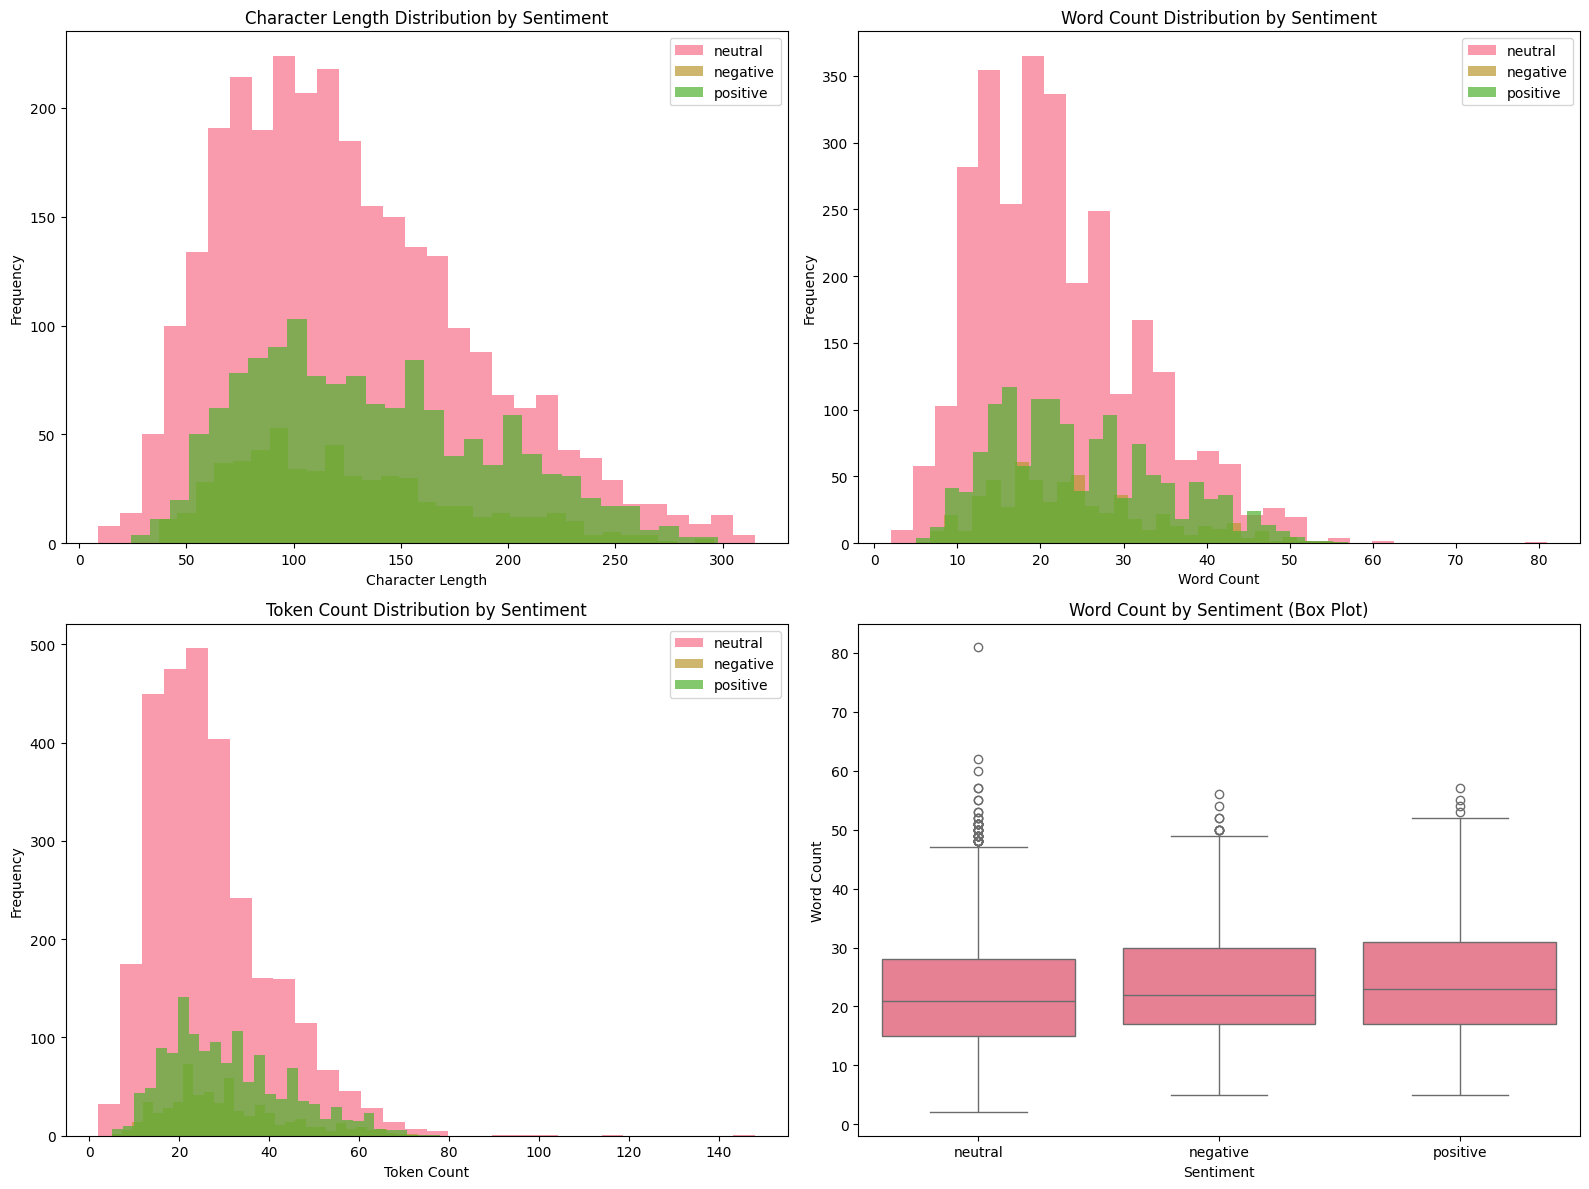

In [6]:
# Text length distribution by sentiment
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
for sentiment in df['sentiment'].unique():
    data = df[df['sentiment'] == sentiment]['text_length']
    axes[0,0].hist(data, alpha=0.7, label=sentiment, bins=30)
axes[0,0].set_title('Character Length Distribution by Sentiment')
axes[0,0].set_xlabel('Character Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Word count distribution
for sentiment in df['sentiment'].unique():
    data = df[df['sentiment'] == sentiment]['word_count']
    axes[0,1].hist(data, alpha=0.7, label=sentiment, bins=30)
axes[0,1].set_title('Word Count Distribution by Sentiment')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Token count distribution
for sentiment in df['sentiment'].unique():
    data = df[df['sentiment'] == sentiment]['num_tokens']
    axes[1,0].hist(data, alpha=0.7, label=sentiment, bins=30)
axes[1,0].set_title('Token Count Distribution by Sentiment')
axes[1,0].set_xlabel('Token Count')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# Box plot for word count by sentiment
sns.boxplot(data=df, x='sentiment', y='word_count', ax=axes[1,1])
axes[1,1].set_title('Word Count by Sentiment (Box Plot)')
axes[1,1].set_xlabel('Sentiment')
axes[1,1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

In [7]:
# Statistical comparison of text lengths by sentiment
print("Text Length Statistics by Sentiment:")
print("\nCharacter Length by Sentiment:")
print(df.groupby('sentiment')['text_length'].describe())
print("\nWord Count by Sentiment:")
print(df.groupby('sentiment')['word_count'].describe())
print("\nToken Count by Sentiment:")
print(df.groupby('sentiment')['num_tokens'].describe())

Text Length Statistics by Sentiment:

Character Length by Sentiment:
            count        mean        std   min   25%    50%    75%    max
sentiment                                                                
negative    604.0  125.730132  52.893977  37.0  85.0  117.5  157.0  296.0
neutral    2879.0  124.884335  57.023295   9.0  81.0  116.0  160.0  315.0
positive   1363.0  135.640499  56.267597  24.0  91.5  128.0  175.0  298.0

Word Count by Sentiment:
            count       mean        std  min   25%   50%   75%   max
sentiment                                                           
negative    604.0  23.917219   9.887414  5.0  17.0  22.0  30.0  56.0
neutral    2879.0  22.166377   9.814317  2.0  15.0  21.0  28.0  81.0
positive   1363.0  24.692590  10.062878  5.0  17.0  23.0  31.0  57.0

Token Count by Sentiment:
            count       mean        std  min   25%   50%   75%    max
sentiment                                                            
negative    604.0  30.4

## Article Chunking Analysis

Chunking Analysis:
Articles with multiple chunks: 0
Articles marked as long: 0
Maximum chunks per article: 1
Average chunks per article: 1.00


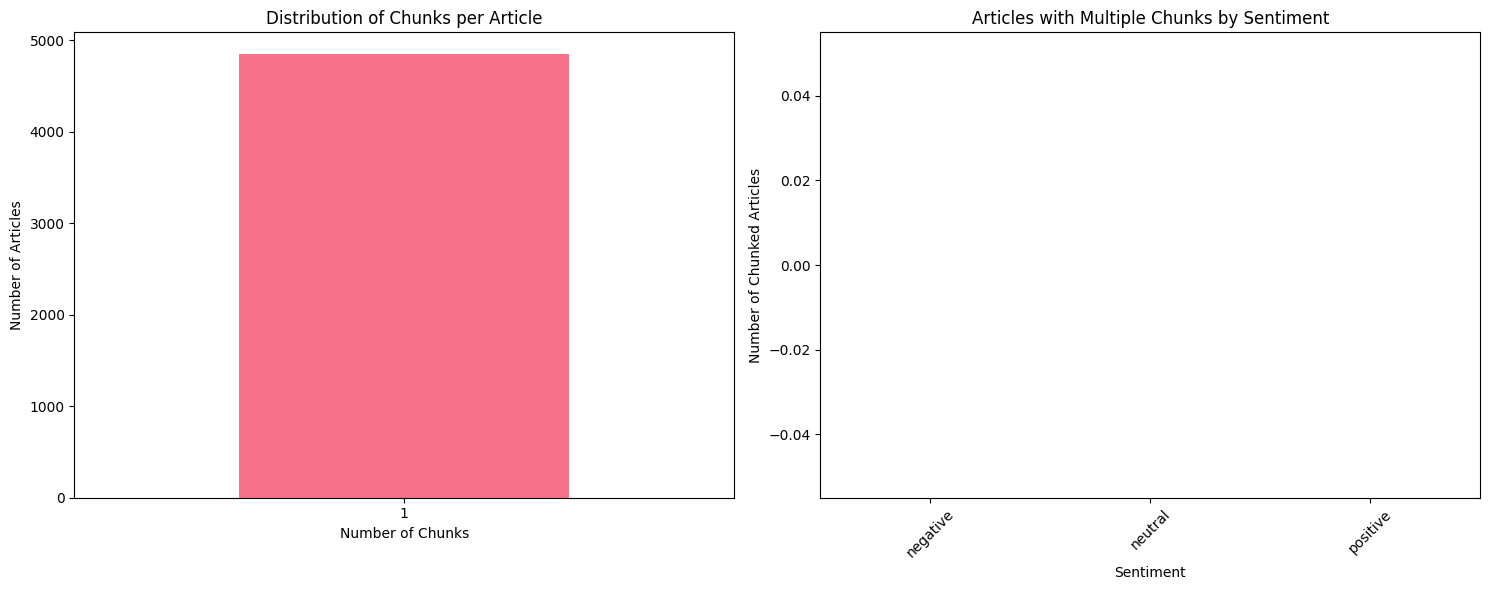

In [8]:
# Analyze chunking patterns
chunk_stats = df.groupby('original_id').agg({
    'total_chunks': 'first',
    'is_long': 'first',
    'sentiment': 'first'
}).reset_index()

print("Chunking Analysis:")
print(f"Articles with multiple chunks: {(chunk_stats['total_chunks'] > 1).sum():,}")
print(f"Articles marked as long: {chunk_stats['is_long'].sum():,}")
print(f"Maximum chunks per article: {chunk_stats['total_chunks'].max()}")
print(f"Average chunks per article: {chunk_stats['total_chunks'].mean():.2f}")

# Chunking distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of chunks per article
chunk_distribution = chunk_stats['total_chunks'].value_counts().sort_index()
chunk_distribution.plot(kind='bar', ax=ax1)
ax1.set_title('Distribution of Chunks per Article')
ax1.set_xlabel('Number of Chunks')
ax1.set_ylabel('Number of Articles')
ax1.tick_params(axis='x', rotation=0)

# Chunking by sentiment
chunking_by_sentiment = chunk_stats.groupby('sentiment')['total_chunks'].apply(
    lambda x: (x > 1).sum()
)
chunking_by_sentiment.plot(kind='bar', ax=ax2, color=['#DC143C', '#2E8B57', '#FFD700'])
ax2.set_title('Articles with Multiple Chunks by Sentiment')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Number of Chunked Articles')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Vocabulary Analysis

In [9]:
# Vocabulary analysis
def get_vocabulary_stats(texts):
    """Calculate vocabulary statistics for a collection of texts."""
    all_words = []
    for text in texts:
        # Simple tokenization - split on whitespace and punctuation
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    return word_counts, len(set(all_words))

# Overall vocabulary
all_word_counts, total_vocab = get_vocabulary_stats(df['text'])
print(f"Total vocabulary size: {total_vocab:,}")
print(f"Total words: {sum(all_word_counts.values()):,}")
print(f"Average word frequency: {sum(all_word_counts.values()) / total_vocab:.2f}")

# Most common words
print("\nTop 20 most common words:")
for word, count in all_word_counts.most_common(20):
    print(f"{word}: {count:,}")

Total vocabulary size: 10,103
Total words: 103,149
Average word frequency: 10.21

Top 20 most common words:
the: 6,069
of: 3,215
in: 2,984
and: 2,596
to: 2,523
a: 1,748
for: 1,152
s: 1,089
eur: 1,018
is: 930
company: 851
will: 850
from: 769
on: 727
its: 646
has: 578
with: 573
by: 559
said: 545
as: 544


Vocabulary size by sentiment:
Neutral: 7,926
Negative: 2,320
Positive: 4,667


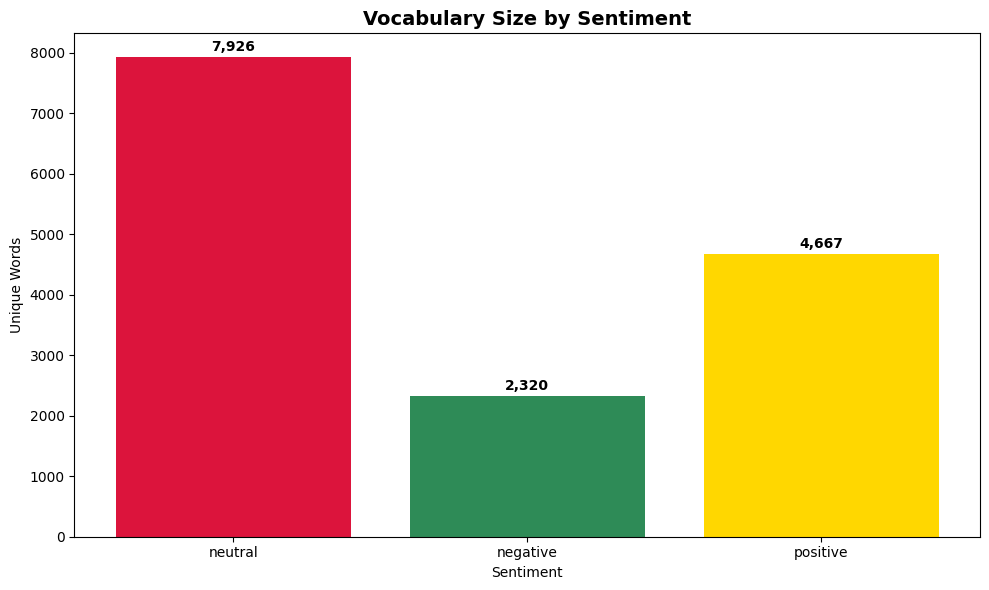

In [10]:
# Vocabulary by sentiment
sentiment_vocab = {}
sentiment_words = {}

for sentiment in df['sentiment'].unique():
    texts = df[df['sentiment'] == sentiment]['text']
    word_counts, vocab_size = get_vocabulary_stats(texts)
    sentiment_vocab[sentiment] = vocab_size
    sentiment_words[sentiment] = word_counts

print("Vocabulary size by sentiment:")
for sentiment, vocab_size in sentiment_vocab.items():
    print(f"{sentiment.capitalize()}: {vocab_size:,}")

# Visualize vocabulary sizes
plt.figure(figsize=(10, 6))
sentiments = list(sentiment_vocab.keys())
vocab_sizes = list(sentiment_vocab.values())
colors = ['#DC143C', '#2E8B57', '#FFD700']

bars = plt.bar(sentiments, vocab_sizes, color=colors)
plt.title('Vocabulary Size by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Unique Words')

# Add value labels on bars
for bar, value in zip(bars, vocab_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Word Frequency Analysis

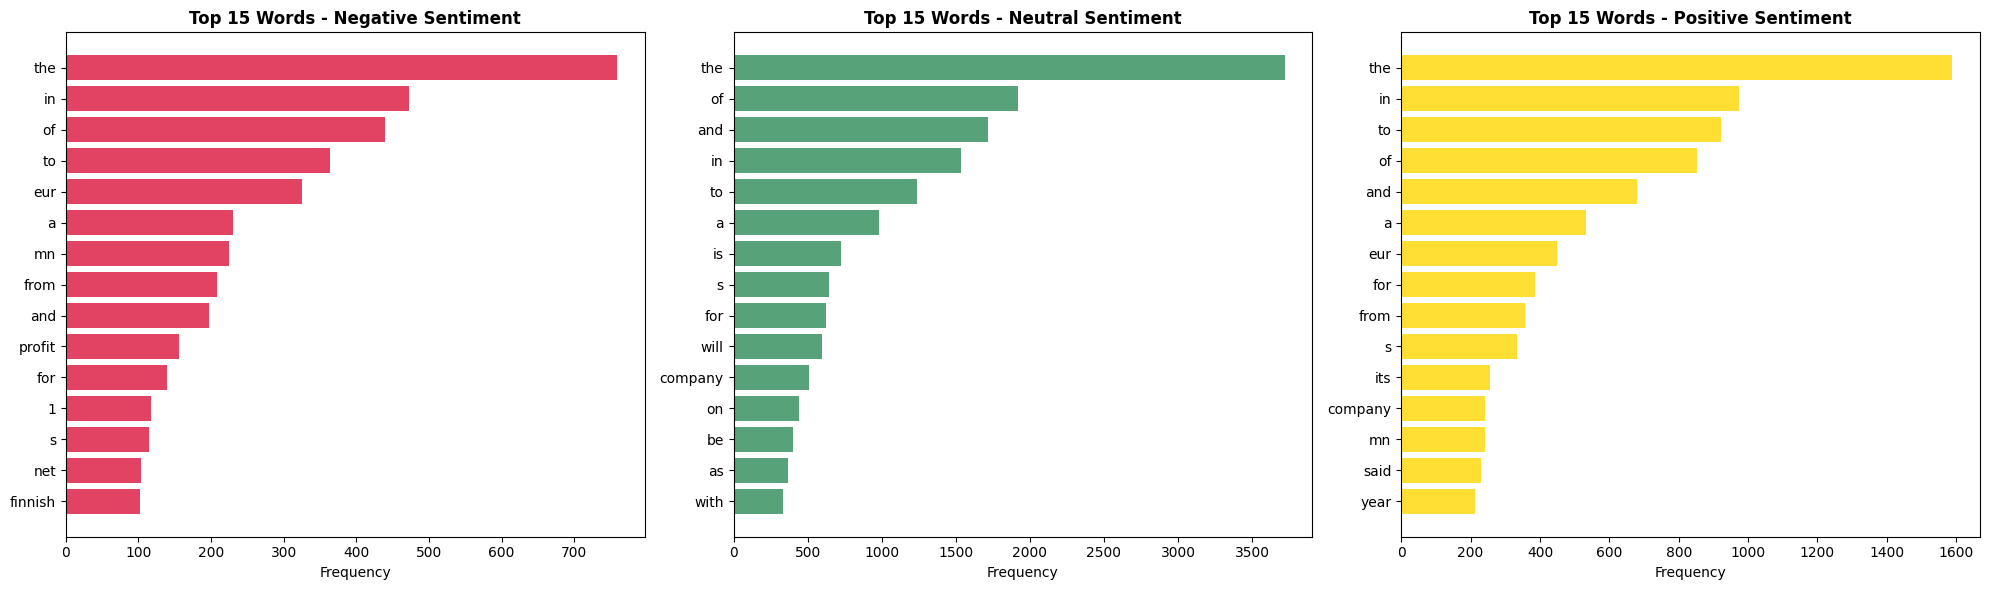

In [11]:
# Most common words by sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sentiments = ['negative', 'neutral', 'positive']
colors = ['#DC143C', '#2E8B57', '#FFD700']

for i, sentiment in enumerate(sentiments):
    if sentiment in sentiment_words:
        top_words = dict(sentiment_words[sentiment].most_common(15))
        words = list(top_words.keys())
        counts = list(top_words.values())
        
        axes[i].barh(words, counts, color=colors[i], alpha=0.8)
        axes[i].set_title(f'Top 15 Words - {sentiment.capitalize()} Sentiment', fontweight='bold')
        axes[i].set_xlabel('Frequency')
        axes[i].invert_yaxis()

plt.tight_layout()
plt.show()

## Word Clouds

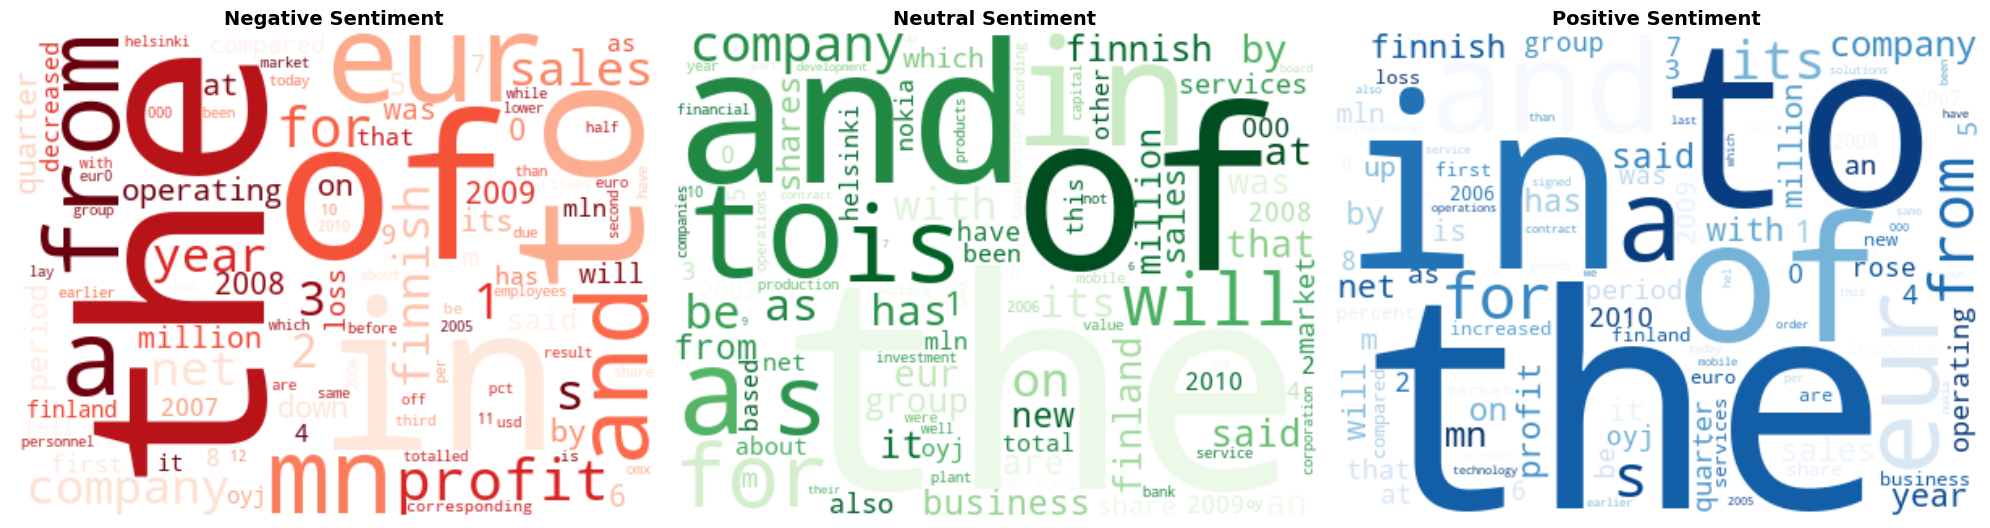

In [12]:
# Create word clouds for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sentiments = ['negative', 'neutral', 'positive']
colors = ['Reds', 'Greens', 'Blues']

for i, sentiment in enumerate(sentiments):
    if sentiment in sentiment_words:
        # Create word cloud
        wordcloud = WordCloud(
            width=400, height=300, 
            background_color='white',
            colormap=colors[i],
            max_words=100,
            relative_scaling=0.5
        ).generate_from_frequencies(sentiment_words[sentiment])
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.capitalize()} Sentiment', fontsize=14, fontweight='bold')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Sample Text Analysis

In [13]:
# Display sample texts for each sentiment
print("Sample Texts by Sentiment:")
print("=" * 80)

for sentiment in ['negative', 'neutral', 'positive']:
    print(f"\n{sentiment.upper()} SENTIMENT EXAMPLES:")
    print("-" * 50)
    
    samples = df[df['sentiment'] == sentiment]['text'].sample(3, random_state=42)
    
    for i, text in enumerate(samples, 1):
        print(f"\nExample {i}:")
        print(f"Length: {len(text)} characters, {len(text.split())} words")
        print(f"Text: {text}")
        print()

Sample Texts by Sentiment:

NEGATIVE SENTIMENT EXAMPLES:
--------------------------------------------------

Example 1:
Length: 152 characters, 27 words
Text: The company decided at the end of 2008 to temporarily shut down its ammonia plant in Billingham and extend the maintenance period at its Ince facility .


Example 2:
Length: 182 characters, 43 words
Text: down to EUR5 .9 m H1 '09 3 August 2009 - Finnish media group Ilkka-Yhtyma Oyj ( HEL : ILK2S ) said today its net profit fell 45 % on the year to EUR5 .9 m in the first half of 2009 .


Example 3:
Length: 262 characters, 44 words
Text: The steelmaker said that the drop in profit was explained by the continuing economic uncertainty , mixed with the current drought in bank lending , resulting in a decline in demand for its products as customers find it increasingly difficult to fund operations .


NEUTRAL SENTIMENT EXAMPLES:
--------------------------------------------------

Example 1:
Length: 172 characters, 27 words
Text: The ce

## Financial Domain Keywords Analysis

Financial Keywords Frequency:
company: 853
share: 500
sales: 455
year: 451
million: 442
profit: 433
market: 345
quarter: 312
business: 292
increase: 217
loss: 161
stock: 152
financial: 140
investment: 134
percent: 133


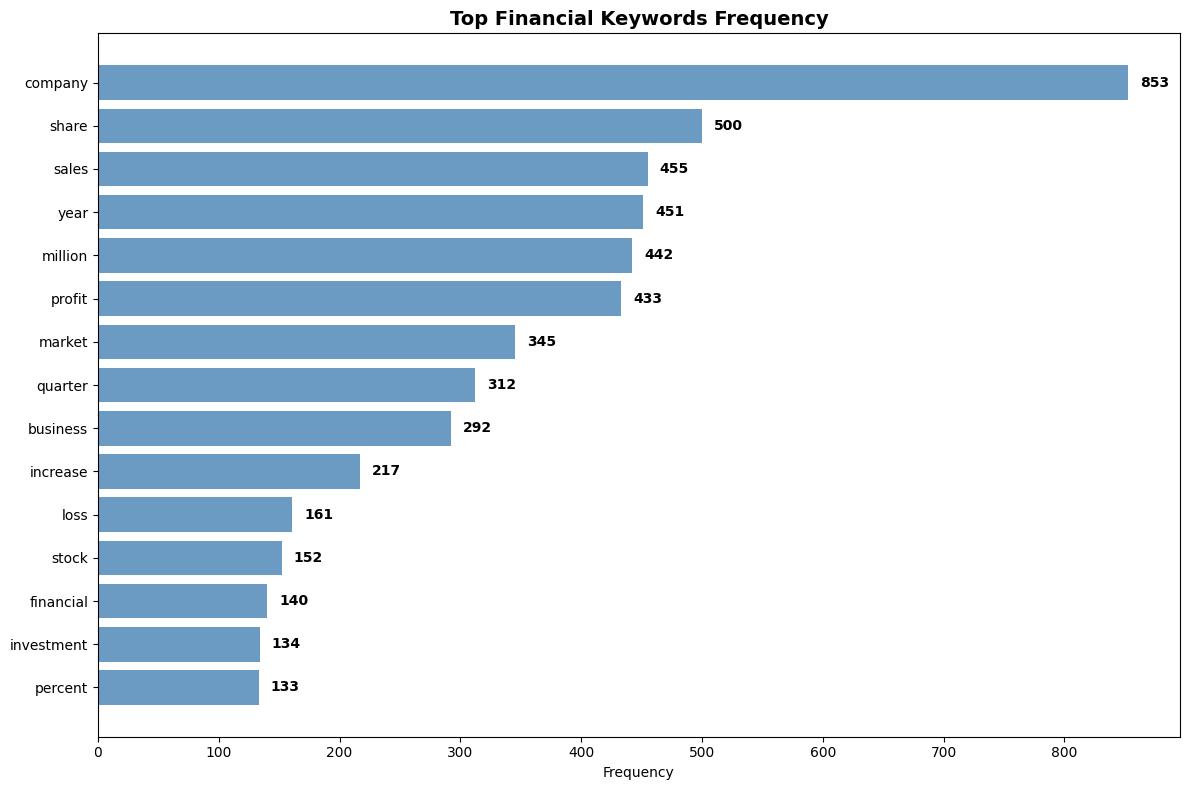

In [14]:
# Define financial keywords to analyze
financial_keywords = [
    'company', 'revenue', 'profit', 'loss', 'growth', 'sales', 'market', 
    'investment', 'stock', 'share', 'dividend', 'earnings', 'financial',
    'business', 'quarter', 'year', 'million', 'billion', 'percent',
    'increase', 'decrease', 'rise', 'fall', 'performance', 'results'
]

# Count occurrences of financial keywords
keyword_counts = {}
for keyword in financial_keywords:
    count = df['text'].str.lower().str.count(keyword).sum()
    if count > 0:
        keyword_counts[keyword] = count

# Sort by frequency
sorted_keywords = dict(sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True))

print("Financial Keywords Frequency:")
for keyword, count in list(sorted_keywords.items())[:15]:
    print(f"{keyword}: {count:,}")

# Visualize top financial keywords
plt.figure(figsize=(12, 8))
top_keywords = dict(list(sorted_keywords.items())[:15])
words = list(top_keywords.keys())
counts = list(top_keywords.values())

plt.barh(words, counts, color='steelblue', alpha=0.8)
plt.title('Top Financial Keywords Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

# Add value labels
for i, (word, count) in enumerate(top_keywords.items()):
    plt.text(count + 10, i, f'{count:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Sentiment Keywords Analysis

Sentiment Indicator Analysis:
  sentiment  positive_indicators  negative_indicators  positive_per_text  \
0   neutral                  154                  125           0.053491   
1  negative                   37                  255           0.061258   
2  positive                  359                  102           0.263390   

   negative_per_text  total_texts  
0           0.043418         2879  
1           0.422185          604  
2           0.074835         1363  


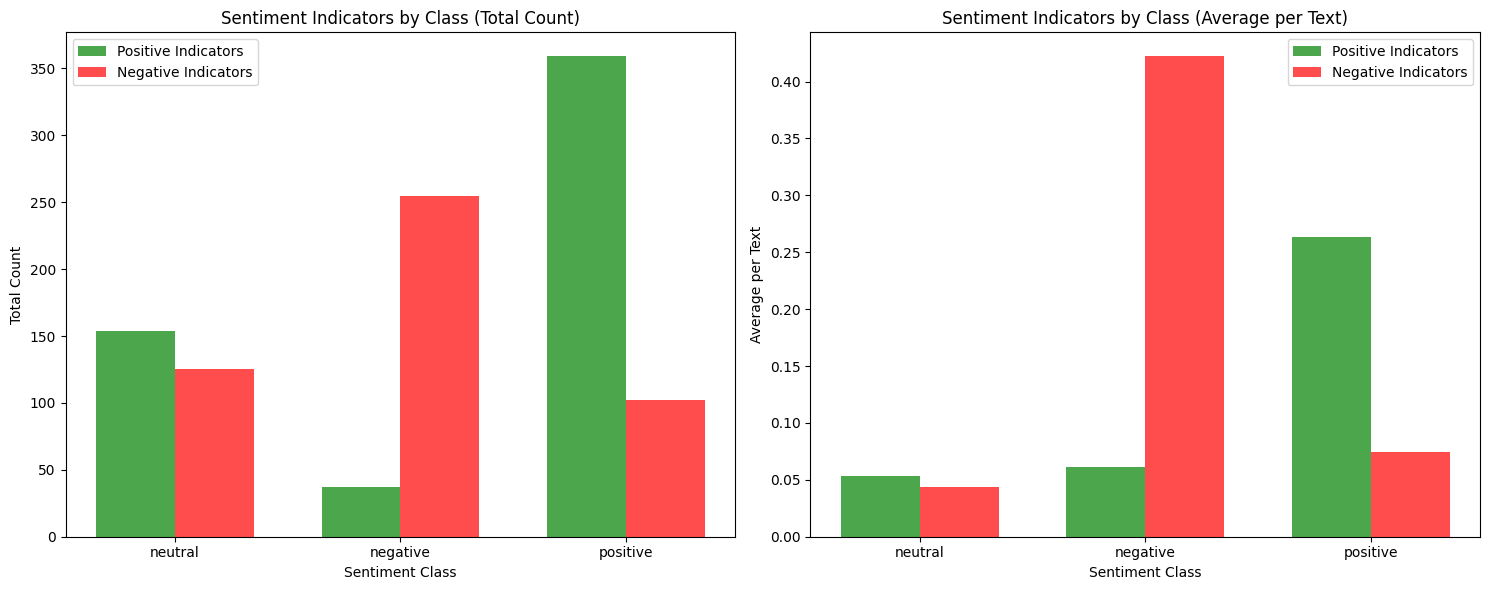

In [15]:
# Analyze sentiment-indicating words
positive_indicators = ['good', 'great', 'excellent', 'strong', 'growth', 'increase', 
                      'improvement', 'success', 'positive', 'rise', 'gain', 'benefit']
negative_indicators = ['bad', 'poor', 'weak', 'decline', 'decrease', 'loss', 'fall',
                      'negative', 'problem', 'issue', 'concern', 'risk', 'drop']

def count_indicators(texts, indicators):
    """Count sentiment indicator words in texts."""
    total_count = 0
    for text in texts:
        text_lower = text.lower()
        for indicator in indicators:
            total_count += text_lower.count(indicator)
    return total_count

# Count indicators by sentiment class
indicator_analysis = []
for sentiment in df['sentiment'].unique():
    texts = df[df['sentiment'] == sentiment]['text']
    pos_count = count_indicators(texts, positive_indicators)
    neg_count = count_indicators(texts, negative_indicators)
    total_texts = len(texts)
    
    indicator_analysis.append({
        'sentiment': sentiment,
        'positive_indicators': pos_count,
        'negative_indicators': neg_count,
        'positive_per_text': pos_count / total_texts,
        'negative_per_text': neg_count / total_texts,
        'total_texts': total_texts
    })

indicator_df = pd.DataFrame(indicator_analysis)
print("Sentiment Indicator Analysis:")
print(indicator_df)

# Visualize sentiment indicators
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Total counts
x = np.arange(len(indicator_df))
width = 0.35

ax1.bar(x - width/2, indicator_df['positive_indicators'], width, label='Positive Indicators', color='green', alpha=0.7)
ax1.bar(x + width/2, indicator_df['negative_indicators'], width, label='Negative Indicators', color='red', alpha=0.7)
ax1.set_xlabel('Sentiment Class')
ax1.set_ylabel('Total Count')
ax1.set_title('Sentiment Indicators by Class (Total Count)')
ax1.set_xticks(x)
ax1.set_xticklabels(indicator_df['sentiment'])
ax1.legend()

# Per text averages
ax2.bar(x - width/2, indicator_df['positive_per_text'], width, label='Positive Indicators', color='green', alpha=0.7)
ax2.bar(x + width/2, indicator_df['negative_per_text'], width, label='Negative Indicators', color='red', alpha=0.7)
ax2.set_xlabel('Sentiment Class')
ax2.set_ylabel('Average per Text')
ax2.set_title('Sentiment Indicators by Class (Average per Text)')
ax2.set_xticks(x)
ax2.set_xticklabels(indicator_df['sentiment'])
ax2.legend()

plt.tight_layout()
plt.show()

## Data Quality Assessment

In [16]:
# Data quality checks
print("Data Quality Assessment:")
print("=" * 50)

# Check for empty or very short texts
empty_texts = df[df['text'].str.len() == 0]
short_texts = df[df['text'].str.len() < 10]
very_long_texts = df[df['text'].str.len() > 1000]

print(f"Empty texts: {len(empty_texts)}")
print(f"Very short texts (<10 chars): {len(short_texts)}")
print(f"Very long texts (>1000 chars): {len(very_long_texts)}")

# Check for duplicate texts
duplicate_texts = df[df.duplicated('text', keep=False)]
print(f"Duplicate texts: {len(duplicate_texts)}")

# Check sentiment label consistency
unique_sentiments = df['sentiment'].unique()
print(f"\nUnique sentiment labels: {unique_sentiments}")

# Check for potential encoding issues
special_chars = df['text'].str.contains(r'[^\w\s.,!?;:()\-\'"]+', regex=True).sum()
print(f"Texts with special characters: {special_chars}")

# Display examples of potential issues
if len(short_texts) > 0:
    print("\nExamples of very short texts:")
    for i, text in enumerate(short_texts['text'].head(3)):
        print(f"{i+1}. '{text}'")

if len(duplicate_texts) > 0:
    print("\nExamples of duplicate texts:")
    duplicates = duplicate_texts.groupby('text').size().head(3)
    for text, count in duplicates.items():
        print(f"Text appears {count} times: '{text[:100]}...'")

Data Quality Assessment:
Empty texts: 0
Very short texts (<10 chars): 1
Very long texts (>1000 chars): 0
Duplicate texts: 16

Unique sentiment labels: ['neutral' 'negative' 'positive']
Texts with special characters: 961

Examples of very short texts:
1. 'Welcome !'

Examples of duplicate texts:
Text appears 2 times: 'Ahlstrom 's share is quoted on the NASDAQ OMX Helsinki ....'
Text appears 2 times: 'Proha Plc ( Euronext :7327 ) announced today ( 19 May ) that its fully-owned subsidiary , Safran Sof...'
Text appears 2 times: 'SSH Communications Security Corporation is headquartered in Helsinki , Finland ....'


## Train/Validation/Test Split Analysis

Train set: 3,876 samples
Validation set: 484 samples
Test set: 486 samples


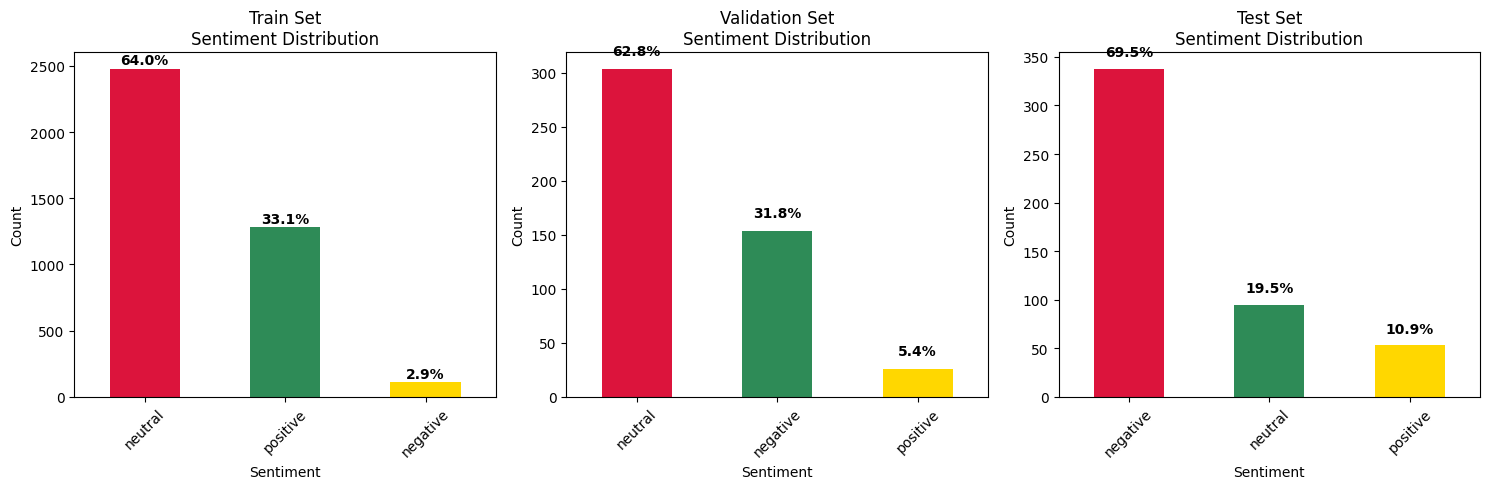


Split Summary:
     Split  Total    Negative      Neutral     Positive
     Train   3876  112 (2.9%) 2480 (64.0%) 1284 (33.1%)
Validation    484 154 (31.8%)  304 (62.8%)    26 (5.4%)
      Test    486 338 (69.5%)   95 (19.5%)   53 (10.9%)


In [17]:
# Load and analyze the splits
splits = {}
split_files = {
    'train': '../data/financial_news/all-data_train.csv',
    'validation': '../data/financial_news/all-data_val.csv',
    'test': '../data/financial_news/all-data_test.csv'
}

for split_name, file_path in split_files.items():
    try:
        split_df = pd.read_csv(file_path)
        splits[split_name] = split_df
        print(f"{split_name.capitalize()} set: {len(split_df):,} samples")
    except FileNotFoundError:
        print(f"{split_name.capitalize()} file not found: {file_path}")

if splits:
    # Analyze sentiment distribution across splits
    fig, axes = plt.subplots(1, len(splits), figsize=(15, 5))
    if len(splits) == 1:
        axes = [axes]
    
    for i, (split_name, split_df) in enumerate(splits.items()):
        sentiment_dist = split_df['sentiment'].value_counts()
        sentiment_dist.plot(kind='bar', ax=axes[i], color=['#DC143C', '#2E8B57', '#FFD700'])
        axes[i].set_title(f'{split_name.capitalize()} Set\nSentiment Distribution')
        axes[i].set_xlabel('Sentiment')
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add percentage labels
        total = len(split_df)
        for j, v in enumerate(sentiment_dist.values):
            pct = (v / total) * 100
            axes[i].text(j, v + 10, f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Create summary table
    split_summary = []
    for split_name, split_df in splits.items():
        sentiment_counts = split_df['sentiment'].value_counts()
        summary = {'Split': split_name.capitalize(), 'Total': len(split_df)}
        for sentiment in ['negative', 'neutral', 'positive']:
            count = sentiment_counts.get(sentiment, 0)
            pct = (count / len(split_df)) * 100
            summary[f'{sentiment.capitalize()}'] = f'{count} ({pct:.1f}%)'
        split_summary.append(summary)
    
    summary_df = pd.DataFrame(split_summary)
    print("\nSplit Summary:")
    print(summary_df.to_string(index=False))